In [1]:
import os
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def avgPdata(data_path: str, par_num: str, mask_size: tuple) -> nib.Nifti1Image:
    # find the participant number
    fstr = lambda x: int(x.split("/")[-1].split("_")[-1].split(".nii.gz")[0].split("s")[-1])
    files = [x for x in data_path if par_num == fstr(x)]
    n = len(files)
    # returned averaged data
    data = np.zeros(mask_size)
    # compute the average
    for idx, f in enumerate(files):
        data_obj = nib.load(f)
        if idx == n - 1:
            affine = data_obj.affine
        # doing it recursively
        data += (1/(idx+1)) * (np.array(data_obj.dataobj) - data)
    return nib.Nifti1Image(data, affine=affine)

In [26]:
def toppvol(data: np.array, p: int, affine: np.array, binary: bool = False, nifti: bool = True) -> nib.Nifti1Image:
    dcopy = data.copy()
    pcent = np.percentile(dcopy, p)
    
    if binary:
        dcopy[dcopy < pcent] = 0
        dcopy[dcopy >= pcent] = 1
    else:
        dcopy[dcopy < pcent] = 0
    
    if nifti:
        return nib.Nifti1Image(dcopy, affine=affine)
    return dcopy

def simple_group_stats(data_objs: list, p: int, binary: bool, nifti: bool, shape: tuple) -> nib.Nifti1Image:
    """
    for each subject, make a volume where a voxel is 1 if it was in the top 1% for
    that subject/layer and 0 if it wasn’t (edited) 
    this should give you 16 volumes per layer (because 16 subjects)
    then sum across subjects so you get a volume per layer
    and look how it changes
    """
    # to save layer specific images
    result = np.zeros(shape)
    
    #sn = lambda x: x.split("_")[-1].split(".")[0]
    
    for do in data_objs:
        result += toppvol(do.dataobj, p=p, affine=do.affine, binary=binary, nifti=nifti)
    
    return nib.Nifti1Image(result, affine=data_objs[0].affine)

In [44]:
MASK_SHAPE = (61, 73, 61)
TOTAL_PARS = 17

INFO = {
    "CV": {
            "LAYERS": (1, 4, 7, 9, 11),
            "DIR": "/media/yoel/second_ssd/neu502b/results/rsak10/",
            "fl": lambda x: int(x.split("relu")[-1].split("cormat")[0]),
            "fp": lambda x: int(x.split("/")[-1].split("relu")[0][1])
          },
    "FC": {
            "LAYERS": (2, 5, 6),
            "DIR": "/media/yoel/second_ssd/neu502b/results/rsak10fc/",
            "fl": lambda x: int(x.split("fc")[-1].split("cormat")[0]),
            "fp": lambda x: int(x.split("/")[-1].split("fc")[0][1])
          }
}

for net_layer_type in ["CV", "FC"]:
    RSA_DIR = INFO[net_layer_type]["DIR"]
    layers = {l:[] for l in INFO[net_layer_type]["LAYERS"]}
    for x in os.listdir(RSA_DIR):
        layers[INFO[net_layer_type]["fl"](x)].append(os.path.join(RSA_DIR, x))
    group = {}
    for l in INFO[net_layer_type]["LAYERS"]:
        group[l] = simple_group_stats(
            [avgPdata(layers[l], i+1, MASK_SHAPE) for i in range(TOTAL_PARS)],
            99, True, False, MASK_SHAPE
        )
    INFO[net_layer_type]["group"] = group

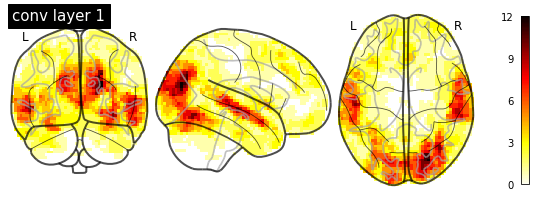

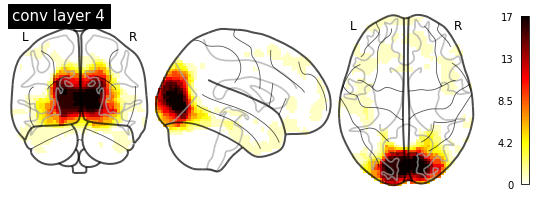

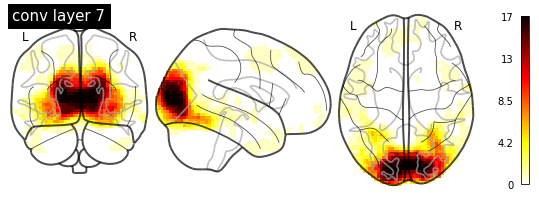

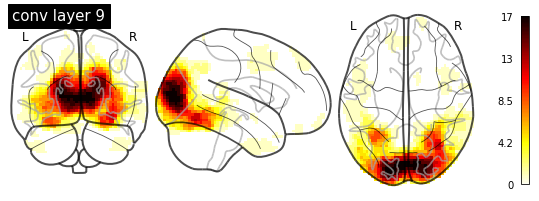

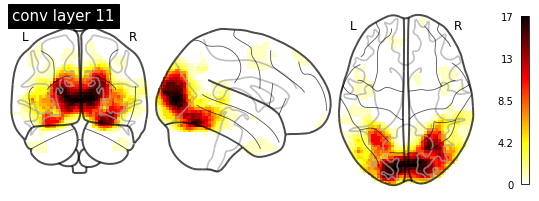

In [49]:
for l in INFO["CV"]["group"].keys():
    plotting.plot_glass_brain(
        INFO["CV"]["group"][l], 
        colorbar=True,
        title="conv layer {}".format(l)
    )

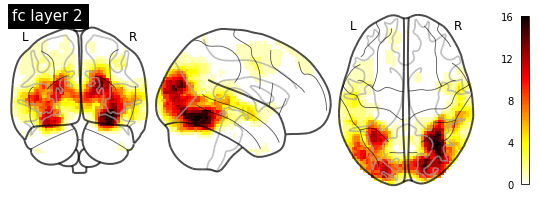

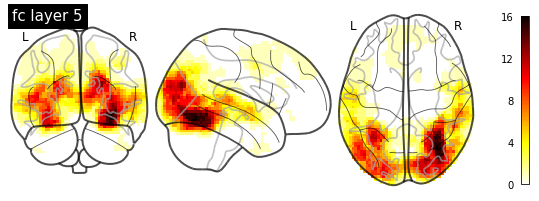

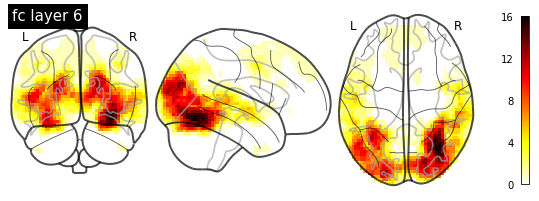

In [50]:
for l in INFO["FC"]["group"].keys():
    plotting.plot_glass_brain(
        INFO["FC"]["group"][l], 
        colorbar=True,
        title="fc layer {}".format(l)
    )

In [51]:
from torchvision import models

In [52]:
axnet = models.alexnet(pretrained=True).eval()

In [53]:
axnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [55]:
import pandas as pd
regressors = pd.read_excel("/media/yoel/second_ssd/neu502b/reqs/regressor_file.xlsx")

In [56]:
regressors

,Segment Number,Scene Title,Start Time (s),End Time (s),Start TR,Scene Details - A Level,Scene Details - B Level,Original B Levels (Janice) fixed,Space-In/Outdoor,Who-N/G/M,...,Name - Focus,Name - Speaking,Location,Camera Angle,Words on Screen,Music Presence,Temporal Relationship,Type of Jump,Arousal,valence
0,1.0,Cartoon Intro,0.0,12.0,0.0,"People in popcorn, candy, and soft drink costu...","1. Cartoon introduction - singers repeat ""Let'...",1. Cartoon,Indoor,G,...,Cartoon People in Costumes,Cartoon People in Costumes,Cartoon World,Long,NaN,Yes,NaN,NaN,3.0,+
1,2.0,NaN,12.0,15.0,8.0,Popcorn is being popped in a large popcorn mac...,Segment 1-7,NaN,Indoor,G,...,NaN,Female Singer,Cartoon World,Medium,NaN,Yes,NaN,NaN,3.0,+
2,3.0,NaN,15.0,17.0,10.0,"Men sing in reply: ""the popcorn can't be beat!""",,NaN,Indoor,G,...,NaN,Male Singers,Cartoon World,Medium,NaN,Yes,NaN,NaN,3.0,+
3,4.0,NaN,17.0,23.0,11.0,"A family of four, a father with a black suit, ...",,NaN,Indoor,G,...,NaN,Background Singers,Cartoon World,Medium,NaN,Yes,NaN,NaN,3.0,+
4,5.0,NaN,23.0,29.0,15.0,A view of the lobby with a display of snacks f...,,NaN,Indoor,G,...,Cartoon Woman,Background Singers,Cartoon World,Medium,NaN,Yes,NaN,NaN,3.0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,997.0,NaN,2950.0,2951.0,1967.0,Sherlock has finished putting on his scarf whe...,,NaN,Indoor,M,...,Sherlock,Sherlock,221B Baker Street Suite,Medium,NaN,Yes,NaN,NaN,5.0,+
995,998.0,NaN,2951.0,2954.0,1967.0,"John says: ""She said… You get off on this. You...",,NaN,Indoor,M,...,John,John,221B Baker Street Suite,Medium,NaN,Yes,NaN,NaN,5.0,+
996,999.0,NaN,2954.0,2962.0,1969.0,"Sherlock smirks and nonchalantly says: ""And I ...",,NaN,Indoor,M,...,Sherlock,Sherlock,221B Baker Street Suite,Medium,NaN,Yes,NaN,NaN,5.0,+
997,1000.0,NaN,2962.0,2964.0,1975.0,"John sits thoughtfully for a few seconds, then...",,NaN,Indoor,M,...,John,John,221B Baker Street Suite,Medium,NaN,Yes,NaN,NaN,5.0,+
